In [1]:
import glob
from astropy.table import Table
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = glob.glob('./phoenix/convolved/*')

In [3]:
f = Table.read(files[1])

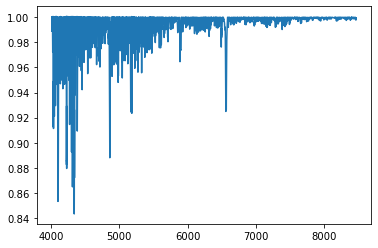

In [4]:
i, j = 80000, 200000

plt.plot(f['Wavelength'][i:j] * 10000, f['norm_fl'][i:j])

In [5]:
f

Wavelength,Flux,smooth_fl,norm_fl
um,W / (m2 um),,
float32,float32,float64,float64
0.01,0.0,-6.51925802230835e-09,-0.9106403245628876
0.010005,0.0,4.734499379835827e-09,0.6743550993050851
0.01001,0.0,1.3052244714671587e-08,1.8644097988534674
0.010015,0.0,4.702693407166846e-10,0.06736712007307791
0.01002,0.0,2.7353159748828154e-09,0.392968324311699
0.010025,0.0,8.402795809700566e-09,1.0704212347006075
0.01003,0.0,-3.400673639983148e-09,-0.4409708216084829
0.010035,0.0,8.654699129153242e-10,0.11427477239307446


In [11]:
import numpy as np
from astropy.io import fits
import pickle 

def build_grid(path = './phoenix/convolved/', wl_range = (4000, 10000)):
    # lte{Teff/10}-{Logg}{[M/H]}a[alpha/H].GRIDNAME.7.spec.gz/bz2/xz
    files = glob.glob(path + str('*.fits'))
    
    wl_min, wl_max = wl_range[0], wl_range[1]
    c = 3e8
    
    grid = {}
    
    T_max = 7100
    T_min = 7000
    T_step = 100
    
    logg_max = 5.5
    logg_min = 2.5
    logg_step = 0.5
    
    rv_max = 250
    rv_min = -250
    rv_step = 25
        
    for T in np.arange(T_min, T_max, T_step):
        temp = [s for s in files if str(T / 100) in s]
        
        grid[T] = {}
        
        for g in np.arange(logg_min, logg_max, logg_step):
            file = [s for s in temp if '-' + str(g) + '-' in s]
            print("Teff: {}, logg: {} == {}".format(T, g, file))
                
            grid[T][g] = {}
            
            spec = fits.open(file[0])
            spec[1].data['Wavelength'] = spec[1].data['Wavelength'] * 10000
            
            wavl_range = (wl_min<spec[1].data['Wavelength'])*(spec[1].data['Wavelength']<wl_max)#*(wvl<26000)
            
            for rv in np.arange(rv_min, rv_max, rv_step):
                temp_spec = spec
                temp_spec[1].data['Wavelength'] = temp_spec[1].data['Wavelength'] * (1 + rv / c)
                
                sp = np.array([temp_spec[1].data['Wavelength'][wavl_range], temp_spec[1].data['norm_fl'][wavl_range]]).T
                
                #print(sp.shape)
                #sp.resize((2, 6000))
                #print(sp[::60])
                                
                grid[T][g][rv] = sp[::60]
                                
    with open('grid/full_grid_7.pkl', 'wb') as f:
        pickle.dump(grid, f)

Teff: 7000, logg: 2.5 == ['./phoenix/convolved/lte070.0-2.5-0.0a+0.0.BT-Settl.fits']
Teff: 7000, logg: 3.0 == ['./phoenix/convolved/lte070.0-3.0-0.0a+0.0.BT-Settl.fits']
Teff: 7000, logg: 3.5 == ['./phoenix/convolved/lte070.0-3.5-0.0a+0.0.BT-Settl.fits']
Teff: 7000, logg: 4.0 == ['./phoenix/convolved/lte070.0-4.0-0.0a+0.0.BT-Settl.fits']
Teff: 7000, logg: 4.5 == ['./phoenix/convolved/lte070.0-4.5-0.0a+0.0.BT-Settl.fits']
Teff: 7000, logg: 5.0 == ['./phoenix/convolved/lte070.0-5.0-0.0a+0.0.BT-Settl.fits']


In [37]:
def stitch(path = './grid/'):
    files = glob.glob(path + 'full_grid_*.pkl')
    
    grid = {}
    
    for file in files:
        with open(file, 'rb') as f:
            grid.update(pickle.load(f))
            
    return grid

grid = stitch()

with open('grid/full_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

In [38]:
with open('grid/full_grid.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [39]:
loaded_dict

{5000: {2.5: {-250: array([[4.00001660e+03, 9.67993865e-01],
          [4.00121655e+03, 9.79609958e-01],
          [4.00241650e+03, 9.98412253e-01],
          ...,
          [9.99641113e+03, 9.99582608e-01],
          [9.99761133e+03, 9.99592297e-01],
          [9.99881152e+03, 9.99609477e-01]]),
   -225: array([[4.00001343e+03, 9.67993865e-01],
          [4.00121338e+03, 9.79609958e-01],
          [4.00241333e+03, 9.98412253e-01],
          ...,
          [9.99640332e+03, 9.99582608e-01],
          [9.99760352e+03, 9.99592297e-01],
          [9.99880371e+03, 9.99609477e-01]]),
   -200: array([[4.00001074e+03, 9.67993865e-01],
          [4.00121069e+03, 9.79609958e-01],
          [4.00241064e+03, 9.98412253e-01],
          ...,
          [9.99639648e+03, 9.99582608e-01],
          [9.99759668e+03, 9.99592297e-01],
          [9.99879688e+03, 9.99609477e-01]]),
   -175: array([[4.00000830e+03, 9.67993865e-01],
          [4.00120825e+03, 9.79609958e-01],
          [4.00240820e+03, 9.98412